In [45]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage as sp

In [46]:
#Import image and shape
image_path = "rat.webp"
shape_path = "rat.txt"

image = cv2.imread(image_path)
image = cv2.GaussianBlur(image, (3, 3), 0)
original_shape = np.loadtxt(shape_path)
if image is None or original_shape is None:
    print('Could not open the necessary documents')
    exit(0)

#Find the edges and the distance transform of the image
edge_map = cv2.Canny(image, 90, 170)
edge_map = 255 - edge_map
distance_transform = cv2.distanceTransform(edge_map, cv2.DIST_L2, 5)

#Calculate the derivatives of the square of the distance transform
ddepth = cv2.CV_16S
grad_x = cv2.Sobel(distance_transform**2, ddepth, 1, 0)
grad_y = cv2.Sobel(distance_transform**2, ddepth, 0, 1)

In [73]:
#Non-linear optimization to find the parameters of the transformation

#Initialize the transformation as the identity
#[x_scale, x_shear, x_offset, y_shear, y_scale, y_offset]
psi_parameters = np.array([1, 0, 0, 0, 1, 0])

def build_transformation(parameters):
    """
    Build the homogeneous transfomation from the parameters vector
    """
    psi = np.eye(3) 
    psi[:2, :3] = np.array(parameters[:6]).reshape(2, 3)

    return psi

def map_shape(initial_shape, parameters):
    """
    Returns the mapping of the points of the initial shape under the transformation

    Args:
        initial_shape: Array of points of the original shape.
        parameters: Vector with the parameters of the transformation
    """
    psi = build_transformation(parameters)

    ones = np.ones((initial_shape.shape[0], 1))
    homogeneous_shape_coords = np.column_stack((initial_shape,ones))

    homogeneous_final_shape = psi @ homogeneous_shape_coords.T
    
    return (homogeneous_final_shape.T)[:,:2]

def interpolated_gradients(positions):
    """
    Interpolates the sobel derivatives if positions is a non-integer vector

    Args:
        positions: array of coordinates (can be floats)
    """
    x_coords = positions[:, 0]
    y_coords = positions[:, 1]
    coords = np.vstack((y_coords, x_coords))
    
    # Bilinear Interpolation
    gx_interp = sp.map_coordinates(grad_x, coords, order=1, mode='constant', cval=0.0)
    gy_interp = sp.map_coordinates(grad_y, coords, order=1, mode='constant', cval=0.0)
    
    return gx_interp, gy_interp

def sq_log_probability_derivative(positions): 
    """
    Calculates the derivative of the log-probability at the given posistion

    Args:
        positions: Positions on which the L-probability is to be computed
    """
    x_coords = positions[:,0] 
    y_coords = positions[:,1]

    #Get the derivatives in the positions
    gx, gy = interpolated_gradients(positions)

    #Vectors dw'_n/dpsi
    N = positions.shape[0]
    first_vectors = np.zeros((N, 6))
    first_vectors[:, 0] = x_coords
    first_vectors[:, 1] = y_coords
    first_vectors[:, 4] = 1

    second_vectors = np.zeros((N, 6))
    second_vectors[:, 2] = x_coords
    second_vectors[:, 3] = y_coords
    second_vectors[:, 5] = 1

    term1 = (gx * x_coords).reshape(-1, 1) * first_vectors
    term2 = (gy * y_coords).reshape(-1, 1) * second_vectors

    return -(term1 + term2)

def update_transformation(initial_shape, parameters ,lr, eps, max_iter):
    """
    Update the transformation parameters

    Args:
        initial_shape: Initial shape to optimize the transformation.
        lr: Learning rate
        eps: Step stop parameter
        max_iter: Max number of iterations stop parameter
    """
    translated_positions = map_shape(initial_shape, parameters)

    derivatives_per_point = sq_log_probability_derivative(translated_positions)
    dL = np.sum(derivatives_per_point, axis = 0)
    print(dL)

    new_parameters = parameters - lr * dL

    return new_parameters

[-3.12181249e+08 -5.73840625e+08  3.21452067e+08  2.11675370e+08
 -6.90128346e+05  6.95482146e+05]
[ 3121813.49050678  5738406.24633979 -3214520.66582577 -2116753.70462002
     6902.28345809    -6954.82145722]


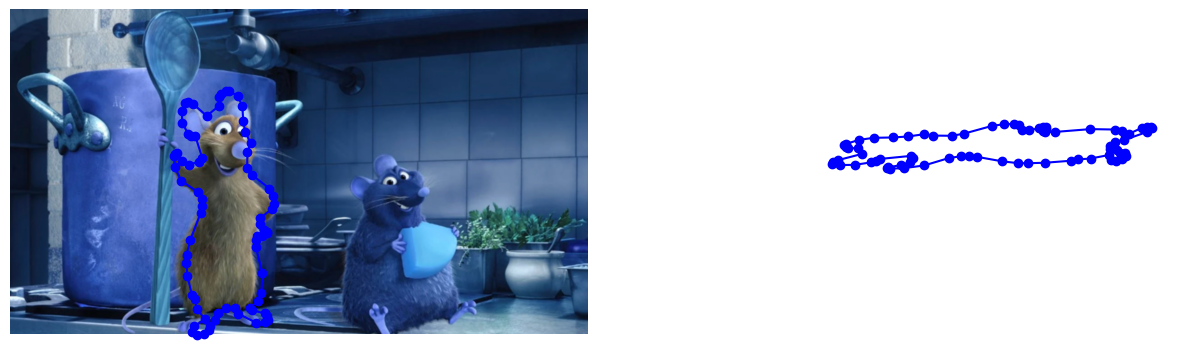

In [74]:
#Plotting window

# plt.plot(original_shape[:,0], original_shape[:,1], marker='o', linestyle='-', color='b', label='Path')
# plt.title('Succession of Points and Connecting Line')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')

#Set the parameters
lr = 0.01

psi_parameters = update_transformation(original_shape, psi_parameters, lr, 4, 5)

print(psi_parameters)

transformed_shape = map_shape(original_shape, psi_parameters)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].axis('off')
ax[0].plot(original_shape[:,0], original_shape[:,1], marker='o', linestyle='-', color='b')

ax[1].imshow(image)
ax[1].axis('off')
ax[1].plot(transformed_shape[:,0], transformed_shape[:,1], marker='o', linestyle='-', color='b')

plt.tight_layout()
plt.show()